# Ideas
- time to days/weekends +
- check time diff for different labels
- geohashes
- tune dbscan
- xgboost +-
- keras RNN

# 2 - троллейбус #7
# 1 - троллейбус #11
# 0 - троллейбус #5

In [1]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
import pandas as pd
import seaborn as sb
import numpy as np
from haversine import haversine
from sklearn.model_selection import KFold
import xgboost as xgb

import matplotlib.pyplot as plt

import datetime as dt

sb.set_context('paper')

%matplotlib inline

/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
data = pd.read_csv(
    'transport_data.csv',
#     na_values='-',
    dtype={'longitude': np.float32, 'latitude': np.float32},
)
cols_to_drop = ['request_ts', 'trans_ts']

data = data.sort_values('trans_ts')

data['req_time'] = data.request_ts.apply(lambda x : dt.datetime.fromtimestamp(x) + dt.timedelta(hours=3))
data['req_month'] = data.req_time.dt.month
data['req_day_of_week'] = data.req_time.dt.dayofweek
data['req_hour'] = data.req_time.dt.hour
data['req_minute'] = data.req_time.dt.minute
data['req_second'] = data.req_time.dt.second
data['req_is_weekend'] = data.req_day_of_week.apply(lambda x: int(x >= 5))

data['trans_time'] = data.trans_ts.apply(lambda x : dt.datetime.fromtimestamp(x) + dt.timedelta(hours=3))
data['trans_hour'] = data.trans_time.dt.hour
data['trans_min'] = data.trans_time.dt.minute
data['trans_second'] = data.trans_time.dt.second
data['minute_of_day'] = data.trans_hour * 60 + data.trans_min
data['trans_day_of_week'] = data.trans_time.dt.dayofweek
data['trans_is_weekend'] = data.trans_day_of_week.apply(lambda x: int(x >= 5))

data['ts_delta'] = data.request_ts - data.trans_ts

test_data = data.loc[data.label == "?"]
# Cleanup data from duplicates: similar data, got during several requests
data = data.drop_duplicates(['longitude', 'latitude', 'trans_ts', 'label'])
data = data.drop(cols_to_drop, axis=1).loc[data.label != "?"]

# test_data = data.loc[data.label == "?"]
# cols_to_drop = ['request_ts', 'trans_ts']
# # cols_to_drop = []
# data = data.drop(cols_to_drop, axis=1).loc[data.label != "?"]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 108660 entries, 0 to 179077
Data columns (total 18 columns):
longitude            108660 non-null float32
latitude             108660 non-null float32
label                108660 non-null object
req_time             108660 non-null datetime64[ns]
req_month            108660 non-null int64
req_day_of_week      108660 non-null int64
req_hour             108660 non-null int64
req_minute           108660 non-null int64
req_second           108660 non-null int64
req_is_weekend       108660 non-null int64
trans_time           108660 non-null datetime64[ns]
trans_hour           108660 non-null int64
trans_min            108660 non-null int64
trans_second         108660 non-null int64
minute_of_day        108660 non-null int64
trans_day_of_week    108660 non-null int64
trans_is_weekend     108660 non-null int64
ts_delta             108660 non-null int64
dtypes: datetime64[ns](2), float32(2), int64(13), object(1)
memory usage: 14.9+ MB


In [46]:
eps = 0.009
for index, row in data.iterrows():
    if row.label == "-":
        data_before = data.loc[(data.trans_ts < row.trans_ts) & (data.label != '-')].tail(1)
        data_after = data.loc[(data.trans_ts > row.trans_ts) & (data.label != '-')].head(1)
        if (not data_before.empty) and (not data_after.empty):
            label_before = data_before.label.values[0]
            label_after = data_after.label.values[0]
            lat_before = data_before.latitude.values[0]
            lon_before = data_before.longitude.values[0]
            lat_after = data_after.latitude.values[0]
            lon_after = data_after.longitude.values[0]
            norm_bf_af = np.linalg.norm(np.array([lat_before, lon_before]) - np.array([lat_after, lon_after]))
            norm_row = np.linalg.norm(np.array([lat_before, lon_before]) - np.array([row.latitude, row.longitude])) \
            + np.linalg.norm(np.array([row.latitude, row.longitude]) - np.array([lat_after, lon_after]))
#             print('a:', data_before, 'b:', data_after)
        else:
            continue
#             and (label_before in ['1', '2'])
        if (label_before == label_after)  and abs(norm_row - norm_bf_af) < eps:
            print(label_before, '|', label_after)
            print("lucky", index)
            data.set_value(index, 'label', label_before)

1 | 1
lucky 18
1 | 1
lucky 42
1 | 1
lucky 41


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:22: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


0 | 0
lucky 99
1 | 1
lucky 118
2 | 2
lucky 139
1 | 1
lucky 281
0 | 0
lucky 329
0 | 0
lucky 339
0 | 0
lucky 341
1 | 1
lucky 354
0 | 0
lucky 402
0 | 0
lucky 407
0 | 0
lucky 408
0 | 0
lucky 422
0 | 0
lucky 502
1 | 1
lucky 542
1 | 1
lucky 527
1 | 1
lucky 528
0 | 0
lucky 565
0 | 0
lucky 611
0 | 0
lucky 646
1 | 1
lucky 650
1 | 1
lucky 665
1 | 1
lucky 688
0 | 0
lucky 705
0 | 0
lucky 741
0 | 0
lucky 742
0 | 0
lucky 759
1 | 1
lucky 868
1 | 1
lucky 871
1 | 1
lucky 882
0 | 0
lucky 912
0 | 0
lucky 914
0 | 0
lucky 955
0 | 0
lucky 1776
0 | 0
lucky 980
0 | 0
lucky 995
0 | 0
lucky 996
0 | 0
lucky 1034
0 | 0
lucky 1021
1 | 1
lucky 1076
1 | 1
lucky 1060
0 | 0
lucky 1142
1 | 1
lucky 1241
1 | 1
lucky 1400
1 | 1
lucky 1417
0 | 0
lucky 1505
0 | 0
lucky 1520
0 | 0
lucky 1560
0 | 0
lucky 1561
0 | 0
lucky 1563
0 | 0
lucky 1579
0 | 0
lucky 1620
0 | 0
lucky 1622
0 | 0
lucky 1627
1 | 1
lucky 1681
0 | 0
lucky 1714
0 | 0
lucky 1750
0 | 0
lucky 1791
2 | 2
lucky 1933
2 | 2
lucky 1934
0 | 0
lucky 1949
0 | 0
lucky 1964

0 | 0
lucky 15598
1 | 1
lucky 15637
0 | 0
lucky 15712
0 | 0
lucky 15745
0 | 0
lucky 15756
0 | 0
lucky 15748
0 | 0
lucky 15764
0 | 0
lucky 15795
0 | 0
lucky 15804
1 | 1
lucky 15842
0 | 0
lucky 15917
0 | 0
lucky 15905
0 | 0
lucky 15932
1 | 1
lucky 15948
1 | 1
lucky 15975
1 | 1
lucky 15965
0 | 0
lucky 16088
1 | 1
lucky 16101
1 | 1
lucky 16175
0 | 0
lucky 16195
2 | 2
lucky 16283
1 | 1
lucky 16298
1 | 1
lucky 16306
0 | 0
lucky 16316
0 | 0
lucky 16428
0 | 0
lucky 16443
0 | 0
lucky 16444
0 | 0
lucky 16574
0 | 0
lucky 16655
0 | 0
lucky 16656
0 | 0
lucky 16702
1 | 1
lucky 16798
0 | 0
lucky 16867
0 | 0
lucky 16875
1 | 1
lucky 16915
0 | 0
lucky 16943
0 | 0
lucky 16929
2 | 2
lucky 16976
0 | 0
lucky 16981
0 | 0
lucky 16989
0 | 0
lucky 16993
0 | 0
lucky 16995
1 | 1
lucky 17015
0 | 0
lucky 17038
0 | 0
lucky 17041
0 | 0
lucky 17097
0 | 0
lucky 17448
0 | 0
lucky 17280
0 | 0
lucky 17320
0 | 0
lucky 17321
0 | 0
lucky 17363
0 | 0
lucky 17374
0 | 0
lucky 17385
0 | 0
lucky 17420
0 | 0
lucky 17515
0 | 0
luck

0 | 0
lucky 32400
2 | 2
lucky 32460
1 | 1
lucky 32552
0 | 0
lucky 32570
0 | 0
lucky 32554
0 | 0
lucky 32629
0 | 0
lucky 32648
0 | 0
lucky 32649
0 | 0
lucky 32633
0 | 0
lucky 32691
1 | 1
lucky 32790
1 | 1
lucky 32792
1 | 1
lucky 32808
1 | 1
lucky 32825
1 | 1
lucky 32826
1 | 1
lucky 32849
1 | 1
lucky 32857
1 | 1
lucky 33013
0 | 0
lucky 33003
0 | 0
lucky 33020
1 | 1
lucky 33204
1 | 1
lucky 33136
1 | 1
lucky 33252
1 | 1
lucky 33254
1 | 1
lucky 33404
1 | 1
lucky 33451
1 | 1
lucky 33473
1 | 1
lucky 33480
1 | 1
lucky 33632
1 | 1
lucky 33608
0 | 0
lucky 33741
0 | 0
lucky 33740
0 | 0
lucky 33743
0 | 0
lucky 33785
1 | 1
lucky 33843
0 | 0
lucky 34012
0 | 0
lucky 34000
1 | 1
lucky 34086
1 | 1
lucky 34087
0 | 0
lucky 34186
0 | 0
lucky 34222
0 | 0
lucky 34296
0 | 0
lucky 34423
2 | 2
lucky 34440
0 | 0
lucky 34602
1 | 1
lucky 34680
0 | 0
lucky 34763
0 | 0
lucky 34847
0 | 0
lucky 34830
1 | 1
lucky 34971
1 | 1
lucky 35004
2 | 2
lucky 35017
2 | 2
lucky 35050
0 | 0
lucky 35127
1 | 1
lucky 35170
0 | 0
luck

0 | 0
lucky 52277
1 | 1
lucky 52317
0 | 0
lucky 52346
0 | 0
lucky 52409
0 | 0
lucky 52699
2 | 2
lucky 52690
2 | 2
lucky 52691
0 | 0
lucky 52713
0 | 0
lucky 52733
2 | 2
lucky 52778
0 | 0
lucky 52827
0 | 0
lucky 53298
0 | 0
lucky 52959
0 | 0
lucky 52987
0 | 0
lucky 53008
2 | 2
lucky 53034
2 | 2
lucky 53118
2 | 2
lucky 53157
0 | 0
lucky 53215
1 | 1
lucky 53262
1 | 1
lucky 53263
2 | 2
lucky 53312
2 | 2
lucky 53367
0 | 0
lucky 53435
0 | 0
lucky 53650
1 | 1
lucky 53787
1 | 1
lucky 53778
1 | 1
lucky 53792
1 | 1
lucky 53869
1 | 1
lucky 53886
1 | 1
lucky 53954
0 | 0
lucky 53968
1 | 1
lucky 54017
1 | 1
lucky 54006
0 | 0
lucky 54027
0 | 0
lucky 54026
0 | 0
lucky 54030
0 | 0
lucky 54083
0 | 0
lucky 54070
0 | 0
lucky 54093
2 | 2
lucky 54143
0 | 0
lucky 54163
0 | 0
lucky 54194
1 | 1
lucky 54252
0 | 0
lucky 54258
0 | 0
lucky 54291
0 | 0
lucky 54292
0 | 0
lucky 54306
2 | 2
lucky 54345
0 | 0
lucky 54404
0 | 0
lucky 54421
0 | 0
lucky 54420
0 | 0
lucky 54423
0 | 0
lucky 54490
2 | 2
lucky 54547
2 | 2
luck

0 | 0
lucky 70400
0 | 0
lucky 70390
1 | 1
lucky 70445
2 | 2
lucky 70459
0 | 0
lucky 70477
0 | 0
lucky 70614
0 | 0
lucky 70643
0 | 0
lucky 70678
1 | 1
lucky 70725
2 | 2
lucky 70776
2 | 2
lucky 70777
2 | 2
lucky 70783
0 | 0
lucky 70839
0 | 0
lucky 70854
0 | 0
lucky 70860
0 | 0
lucky 70876
1 | 1
lucky 70885
1 | 1
lucky 70883
1 | 1
lucky 70944
0 | 0
lucky 70936
0 | 0
lucky 70939
1 | 1
lucky 70950
1 | 1
lucky 70973
1 | 1
lucky 70952
0 | 0
lucky 70999
0 | 0
lucky 71025
0 | 0
lucky 71030
0 | 0
lucky 71051
1 | 1
lucky 71091
0 | 0
lucky 71103
0 | 0
lucky 71121
0 | 0
lucky 71123
1 | 1
lucky 71129
0 | 0
lucky 71162
0 | 0
lucky 71236
1 | 1
lucky 71504
1 | 1
lucky 71503
1 | 1
lucky 71579
1 | 1
lucky 71585
1 | 1
lucky 71589
1 | 1
lucky 71619
2 | 2
lucky 71647
2 | 2
lucky 71648
1 | 1
lucky 71705
1 | 1
lucky 71829
2 | 2
lucky 71838
2 | 2
lucky 71839
2 | 2
lucky 71841
0 | 0
lucky 71930
0 | 0
lucky 71982
2 | 2
lucky 72034
2 | 2
lucky 72086
0 | 0
lucky 72050
0 | 0
lucky 72127
2 | 2
lucky 72135
0 | 0
luck

1 | 1
lucky 89005
0 | 0
lucky 89176
0 | 0
lucky 89253
0 | 0
lucky 89246
1 | 1
lucky 89300
1 | 1
lucky 89446
1 | 1
lucky 89517
0 | 0
lucky 89534
0 | 0
lucky 89690
1 | 1
lucky 89806
1 | 1
lucky 89808
1 | 1
lucky 89848
1 | 1
lucky 89893
1 | 1
lucky 89904
1 | 1
lucky 89921
1 | 1
lucky 89932
1 | 1
lucky 89961
2 | 2
lucky 90103
1 | 1
lucky 90159
1 | 1
lucky 90181
1 | 1
lucky 90345
1 | 1
lucky 90368
1 | 1
lucky 90388
0 | 0
lucky 90439
0 | 0
lucky 90443
1 | 1
lucky 90557
1 | 1
lucky 90606
1 | 1
lucky 90624
1 | 1
lucky 90610
0 | 0
lucky 90635
1 | 1
lucky 90687
0 | 0
lucky 90675
1 | 1
lucky 90730
0 | 0
lucky 90756
0 | 0
lucky 90807
0 | 0
lucky 90861
0 | 0
lucky 90841
0 | 0
lucky 90913
1 | 1
lucky 91050
0 | 0
lucky 91106
0 | 0
lucky 91131
0 | 0
lucky 91136
0 | 0
lucky 91159
1 | 1
lucky 91295
1 | 1
lucky 91296
0 | 0
lucky 91494
0 | 0
lucky 91460
0 | 0
lucky 91626
0 | 0
lucky 91638
0 | 0
lucky 91665
0 | 0
lucky 91727
0 | 0
lucky 91749
0 | 0
lucky 91784
0 | 0
lucky 91789
0 | 0
lucky 91808
2 | 2
luck

1 | 1
lucky 108058
1 | 1
lucky 108059
1 | 1
lucky 108063
1 | 1
lucky 108085
1 | 1
lucky 108070
1 | 1
lucky 108087
1 | 1
lucky 108169
0 | 0
lucky 108221
2 | 2
lucky 108203
1 | 1
lucky 108322
0 | 0
lucky 108534
1 | 1
lucky 108633
1 | 1
lucky 108647
1 | 1
lucky 108751
1 | 1
lucky 108752
1 | 1
lucky 108766
0 | 0
lucky 108812
0 | 0
lucky 108851
1 | 1
lucky 108830
1 | 1
lucky 108950
1 | 1
lucky 109078
1 | 1
lucky 109077
1 | 1
lucky 109080
1 | 1
lucky 109121
1 | 1
lucky 109190
1 | 1
lucky 109340
1 | 1
lucky 109344
1 | 1
lucky 109407
1 | 1
lucky 109438
0 | 0
lucky 109471
1 | 1
lucky 109509
1 | 1
lucky 109560
1 | 1
lucky 109707
1 | 1
lucky 109708
2 | 2
lucky 109719
1 | 1
lucky 109757
2 | 2
lucky 109806
1 | 1
lucky 109859
1 | 1
lucky 109837
1 | 1
lucky 109839
2 | 2
lucky 110008
1 | 1
lucky 110108
1 | 1
lucky 110130
2 | 2
lucky 110146
1 | 1
lucky 110180
0 | 0
lucky 110209
0 | 0
lucky 110228
1 | 1
lucky 110241
1 | 1
lucky 110239
1 | 1
lucky 110243
1 | 1
lucky 110346
1 | 1
lucky 110475
1 | 1
lucky 

1 | 1
lucky 125161
1 | 1
lucky 125198
1 | 1
lucky 125203
0 | 0
lucky 125320
0 | 0
lucky 125332
2 | 2
lucky 125347
2 | 2
lucky 125477
1 | 1
lucky 125498
1 | 1
lucky 125490
2 | 2
lucky 125523
2 | 2
lucky 125534
2 | 2
lucky 125562
0 | 0
lucky 125584
1 | 1
lucky 125613
1 | 1
lucky 125616
2 | 2
lucky 125628
1 | 1
lucky 125665
1 | 1
lucky 125689
2 | 2
lucky 125697
0 | 0
lucky 125755
0 | 0
lucky 125760
0 | 0
lucky 125875
0 | 0
lucky 125910
1 | 1
lucky 125959
1 | 1
lucky 126132
1 | 1
lucky 126126
2 | 2
lucky 126145
1 | 1
lucky 126179
1 | 1
lucky 126182
1 | 1
lucky 126198
1 | 1
lucky 126207
1 | 1
lucky 126212
0 | 0
lucky 126238
1 | 1
lucky 126261
1 | 1
lucky 126277
1 | 1
lucky 126312
1 | 1
lucky 126469
1 | 1
lucky 126495
0 | 0
lucky 126517
0 | 0
lucky 126525
1 | 1
lucky 126546
1 | 1
lucky 126557
1 | 1
lucky 126549
1 | 1
lucky 126560
0 | 0
lucky 126672
1 | 1
lucky 126682
0 | 0
lucky 126755
0 | 0
lucky 126739
0 | 0
lucky 126757
0 | 0
lucky 126834
0 | 0
lucky 126842
0 | 0
lucky 126860
0 | 0
lucky 

0 | 0
lucky 142741
0 | 0
lucky 142787
0 | 0
lucky 142830
0 | 0
lucky 142835
0 | 0
lucky 142877
0 | 0
lucky 142931
0 | 0
lucky 143067
0 | 0
lucky 143069
1 | 1
lucky 143130
0 | 0
lucky 143169
0 | 0
lucky 143170
1 | 1
lucky 143180
1 | 1
lucky 143238
2 | 2
lucky 143273
0 | 0
lucky 143297
1 | 1
lucky 143330
1 | 1
lucky 143334
0 | 0
lucky 143375
0 | 0
lucky 143418
2 | 2
lucky 143441
0 | 0
lucky 143602
2 | 2
lucky 143681
2 | 2
lucky 143724
2 | 2
lucky 143775
1 | 1
lucky 143822
0 | 0
lucky 144025
0 | 0
lucky 144042
0 | 0
lucky 144044
1 | 1
lucky 144170
1 | 1
lucky 144226
0 | 0
lucky 144319
0 | 0
lucky 144285
1 | 1
lucky 144316
2 | 2
lucky 144441
2 | 2
lucky 144428
1 | 1
lucky 144456
0 | 0
lucky 144481
0 | 0
lucky 144503
1 | 1
lucky 144532
0 | 0
lucky 144609
1 | 1
lucky 144610
0 | 0
lucky 144809
0 | 0
lucky 144835
0 | 0
lucky 144860
0 | 0
lucky 144897
0 | 0
lucky 144881
2 | 2
lucky 144951
0 | 0
lucky 145017
1 | 1
lucky 145089
0 | 0
lucky 145159
1 | 1
lucky 145302
1 | 1
lucky 145198
1 | 1
lucky 

0 | 0
lucky 161738
0 | 0
lucky 161733
0 | 0
lucky 161734
0 | 0
lucky 161766
0 | 0
lucky 161783
1 | 1
lucky 161822
0 | 0
lucky 161853
1 | 1
lucky 161942
0 | 0
lucky 162009
0 | 0
lucky 162029
2 | 2
lucky 162037
2 | 2
lucky 162039
2 | 2
lucky 162045
2 | 2
lucky 162060
2 | 2
lucky 162049
2 | 2
lucky 162053
2 | 2
lucky 162052
2 | 2
lucky 162156
0 | 0
lucky 162184
0 | 0
lucky 162202
2 | 2
lucky 162249
2 | 2
lucky 162292
2 | 2
lucky 162397
1 | 1
lucky 162556
2 | 2
lucky 162608
1 | 1
lucky 162644
0 | 0
lucky 162665
0 | 0
lucky 162690
0 | 0
lucky 162719
1 | 1
lucky 162775
1 | 1
lucky 162804
0 | 0
lucky 162828
0 | 0
lucky 162865
0 | 0
lucky 162981
0 | 0
lucky 163028
1 | 1
lucky 163078
2 | 2
lucky 163077
0 | 0
lucky 163090
2 | 2
lucky 163100
0 | 0
lucky 163149
2 | 2
lucky 163153
2 | 2
lucky 163170
0 | 0
lucky 163175
0 | 0
lucky 163176
2 | 2
lucky 163199
0 | 0
lucky 163219
0 | 0
lucky 163305
0 | 0
lucky 163428
0 | 0
lucky 163478
1 | 1
lucky 163483
1 | 1
lucky 163490
0 | 0
lucky 163630
0 | 0
lucky 

1 | 1
lucky 176472
1 | 1
lucky 176468
0 | 0
lucky 176539
0 | 0
lucky 176644
0 | 0
lucky 176781
0 | 0
lucky 176788
0 | 0
lucky 176805
1 | 1
lucky 176989
1 | 1
lucky 176991
1 | 1
lucky 176993
1 | 1
lucky 176996
0 | 0
lucky 177065
2 | 2
lucky 177158
0 | 0
lucky 177188
0 | 0
lucky 177213
0 | 0
lucky 177262
0 | 0
lucky 177279
1 | 1
lucky 177357
1 | 1
lucky 177375
0 | 0
lucky 177416
1 | 1
lucky 177457
1 | 1
lucky 177582
0 | 0
lucky 177644
1 | 1
lucky 177663
1 | 1
lucky 177721
0 | 0
lucky 177783
0 | 0
lucky 177767
1 | 1
lucky 177788
1 | 1
lucky 177777
0 | 0
lucky 177790
0 | 0
lucky 177799
1 | 1
lucky 177829
0 | 0
lucky 177837
0 | 0
lucky 177847
1 | 1
lucky 177900
0 | 0
lucky 177914
0 | 0
lucky 177950
0 | 0
lucky 178076
0 | 0
lucky 178086
0 | 0
lucky 178125
0 | 0
lucky 178227
0 | 0
lucky 178422
0 | 0
lucky 178423
2 | 2
lucky 178432
0 | 0
lucky 178445
0 | 0
lucky 178502
0 | 0
lucky 178523
0 | 0
lucky 178571
0 | 0
lucky 178608
0 | 0
lucky 178609
1 | 1
lucky 178678
0 | 0
lucky 178866
0 | 0
lucky 

In [4]:
data.loc[data.label == '-', 'label'] = np.nan
data = data.dropna()
data.loc[:, 'label'] = pd.to_numeric(data.label)
data.info()

/opt/conda/lib/python3.6/site-packages/pandas/core/ops.py:816: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = getattr(x, name)(y)


TypeError: invalid type comparison

In [26]:
def norm(row):
#     print(row)
#     print(row.values)
    return np.linalg.norm(row.values)
data['norm'] = data.drop(
    ['label', 'trans_time', 'req_time'],
    axis=1
).apply(norm, axis=1)
test_data['norm'] = data.drop(
    ['label', 'trans_time', 'req_time'],
    axis=1
).apply(norm, axis=1)


In [25]:
data.head(10)

,longitude,latitude,label,req_time,req_month,req_day_of_week,req_hour,req_minute,req_second,req_is_weekend,trans_time,trans_hour,trans_min,trans_second,minute_of_day,trans_day_of_week,trans_is_weekend,ts_delta,norm
4,30.360102,59.931103,0,2017-11-29 15:00:27,11,2,15,0,27,0,2017-11-29 14:59:27,14,59,27,899,2,0,60,906.533768
6,30.361664,59.931160,0,2017-11-29 15:00:27,11,2,15,0,27,0,2017-11-29 14:59:34,14,59,34,899,2,0,53,906.333037
16,30.378458,59.940372,1,2017-11-29 15:00:27,11,2,15,0,27,0,2017-11-29 15:00:06,15,0,6,900,2,0,21,903.493608
21,30.354908,59.931911,1,2017-11-29 15:00:27,11,2,15,0,27,0,2017-11-29 15:00:14,15,0,14,900,2,0,13,903.430271
22,30.334095,59.934486,0,2017-11-29 15:00:27,11,2,15,0,27,0,2017-11-29 15:00:16,15,0,16,900,2,0,11,903.436384
33,30.312321,59.937405,2,2017-11-29 15:00:58,11,2,15,0,58,0,2017-11-29 15:00:20,15,0,20,900,2,0,38,905.703224
36,30.378458,59.940372,1,2017-11-29 15:00:58,11,2,15,0,58,0,2017-11-29 15:00:31,15,0,31,900,2,0,27,905.620615
55,30.334095,59.934486,0,2017-11-29 15:01:28,11,2,15,1,28,0,2017-11-29 15:00:36,15,0,36,900,2,0,52,905.470209
47,30.313391,59.936810,1,2017-11-29 15:00:58,11,2,15,0,58,0,2017-11-29 15:00:49,15,0,49,900,2,0,9,906.055364
60,30.360102,59.931103,0,2017-11-29 15:01:28,11,2,15,1,28,0,2017-11-29 15:00:57,15,0,57,900,2,0,31,905.586811


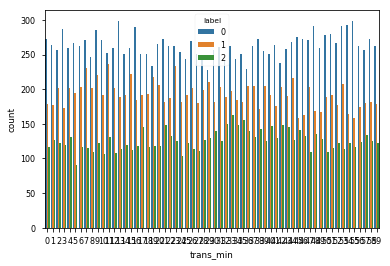

In [55]:
sb.countplot(data=data, x='trans_min', hue='label');

In [9]:
dbscan = DBSCAN(eps=0.1, n_jobs=-1, algorithm='ball_tree', metric=haversine)

In [10]:
cluster = dbscan.fit_predict(data.loc[:, ['longitude', 'latitude']], )

In [11]:
cluster

array([0, 0, 0, ..., 0, 0, 0])

In [12]:
data.loc[:, 'dbscan'] = cluster
# data = data.loc[data.dbscan != -1]

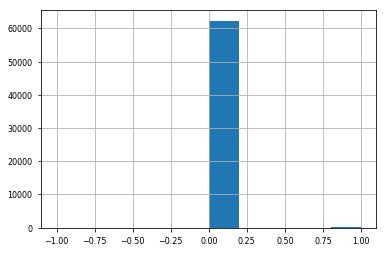

In [13]:
data.dbscan.hist();


In [14]:
accuracy_score(data.label.apply(int), data.dbscan)

0.4973661035945881

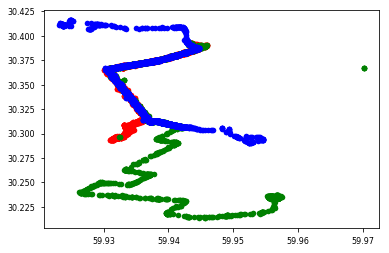

In [39]:
plt.plot(
    data.loc[data.label == 0].latitude, data.loc[data.label == 0].longitude, 'or',
    data.loc[data.label == 1].latitude, data.loc[data.label == 1].longitude, 'og',
    data.loc[data.label == 2].latitude, data.loc[data.label == 2].longitude, 'ob',
);

In [34]:
lg = LogisticRegression()

In [35]:
lg.fit(data.drop(['label', 'trans_time', 'req_time'], axis=1), data.label)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [36]:
pr = lg.predict(data.drop(['label', 'trans_time', 'req_time'], axis=1))

In [28]:
pr = lg.predict(test_data.drop(['label', 'trans_time', 'req_time'], axis=1))

In [38]:
pr

array([0, 0, 0, ..., 1, 1, 1])

In [37]:
accuracy_score(pr, data.label)

0.45673029373949164

In [16]:
import folium
def get_map_for_one_label_day(df, label, month=11, day=29, color='red'):
    m = folium.Map(location=[59, 30], zoom_start=10)
    features = folium.FeatureGroup("1")
    cols = ['latitude', 'longitude', 'trans_time']

    df_label = df.loc[
        (df.label == label) & 
        (df.trans_time.dt.day == day) & 
        (df.trans_time.dt.month == month), 
        cols,
    ]

    for lat, lng, time in df_label.itertuples(index=False):
        features.add_child(folium.Marker(
            location=[lat, lng],
            popup=str(time),
            icon=folium.Icon(color='red', icon='info-sign')),
        )

    m.add_child(features)
    return m

In [17]:
get_map_for_one_label_day(data, '2')

RNN

In [29]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

FEATURES = 16
model = Sequential()
model.add(LSTM(
    32,
    input_shape=(None, FEATURES),
    return_sequences=True),
)
model.add(TimeDistributed(Dense(1, activation='sigmoid')))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

model.fit(
    x=data.drop(['label', 'trans_time', 'req_time'], axis=1).values.reshape(len(data), 1, FEATURES),
    y=data.label.values.reshape(len(data), 1, 1),
    batch_size=5,
    epochs=5,
    verbose=2,
)

yhat = model.predict_classes(data.drop(['label', 'trans_time', 'req_time'], axis=1).values.reshape(len(data), 1, FEATURES), verbose=0)


Epoch 1/5
 - 6s - loss: 0.5240 - acc: 0.3288
Epoch 2/5
 - 6s - loss: 0.5220 - acc: 0.3286
Epoch 3/5
 - 6s - loss: 0.5210 - acc: 0.3286
Epoch 4/5
 - 6s - loss: 0.5211 - acc: 0.3286
Epoch 5/5
 - 6s - loss: 0.5210 - acc: 0.3285


In [ ]:
prn = [str(i[0][0]) for i in yhat]
prn

In [ ]:
accuracy_score(prn, data.label)

In [68]:
data.drop(['label', 'trans_time', 'req_time'], axis=1).values.reshape(len(data), 1, 16)[1][0]

array([  30.36166382,   59.93115997,   11.        ,    2.        ,
         15.        ,    0.        ,   27.        ,    0.        ,
         14.        ,   59.        ,   34.        ,  899.        ,
          2.        ,    0.        ,   53.        ,    0.        ])

In [69]:
data.label.values.reshape(len(data), 1, 1)[1][0]

array(['0'], dtype=object)

XGBoost

In [30]:
baseline_params = {
    'max_depth': 5,
    'objective': 'multi:softmax',
    'num_class': 3,
}

In [31]:
train_base = data[data.label.notnull()].drop(['label', 'req_time', 'trans_time'], axis=1)
labels_base = data.label[data.label.notnull()]
test_base = data[data.label.isnull()].drop(['label', 'req_time', 'trans_time'], axis=1)
X_base = xgb.DMatrix(train_base.values, labels_base.values, feature_names=train_base.columns)
base_xgb = xgb.train(baseline_params, X_base)
base_xgb

In [54]:
train_base.info()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34866 entries, 4 to 179077
Data columns (total 17 columns):
longitude            34866 non-null float32
latitude             34866 non-null float32
request_ts           34866 non-null int64
trans_ts             34866 non-null int64
req_month            34866 non-null int64
req_day_of_week      34866 non-null int64
req_hour             34866 non-null int64
req_minute           34866 non-null int64
req_second           34866 non-null int64
req_is_weekend       34866 non-null int64
trans_hour           34866 non-null int64
trans_min            34866 non-null int64
trans_second         34866 non-null int64
minute_of_day        34866 non-null int64
trans_day_of_week    34866 non-null int64
trans_is_weekend     34866 non-null int64
ts_delta             34866 non-null int64
dtypes: float32(2), int64(15)
memory usage: 4.5 MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 34866 entries, 4 to 179077
Data columns (total 20 columns):
longitude  

In [32]:
base_result = base_xgb.predict(
    xgb.DMatrix(
        data.drop(['label', 'req_time', 'trans_time'], axis=1).values,
        feature_names=data.drop(['label', 'req_time', 'trans_time'], axis=1).columns
    )
)
list(map(int, base_result))
accuracy_score(list(map(int, base_result)), data.label)

0.56232486071275511

In [41]:
base_result = base_xgb.predict(
    xgb.DMatrix(
        test_data.drop(['label', 'req_time', 'trans_time', 'request_ts', 'trans_ts'], axis=1).values,
        feature_names=test_data.drop(['label', 'req_time', 'trans_time', 'request_ts', 'trans_ts'], axis=1).columns
    )
)
list(map(int, base_result))

[1,
 0,
 0,
 0,
 2,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [59]:
np.savetxt('data/base.txt', list(map(int, base_result)), fmt='%1i')

In [42]:
len(base_result)

12000